# Single Qubit Parametrized Circuit Training

In this project we train a parametrized circuit to first turn an $\ket{0}$ state into a $\ket{1}$ state, then a $\ket{\psi}$ state into $\ket{1}$ by training the parameter ($\theta$) of a single $R_Y$ gate and using gradient descent.

We use the cost function $$C_\psi(\theta)=\langle(R_Y(\theta)\ket{\psi})|Z|(R_Y(\theta)\ket{\psi})\rangle,$$ that is, the expectation value of the Pauli Z operator after applying $R_Y$ to an initial state $\ket{\psi}$. In the first part of this notebook, we let $\ket{\psi}=\ket{0}$, and in the second part, we choose a random $\ket{\psi}$ and let the training occur.

## Preliminaries

### The Cost Function

The expression $$C_\psi(\theta)=\langle(R_Y(\theta)\ket{\psi})|Z|(R_Y(\theta)\ket{\psi})\rangle$$ is minimized (equals -1) when $R_Y(\theta)\ket{\psi}$ is closest to $\ket{1}$, making it a suitable candidate for a cost function.

### Gradient Descent

Gradient Descent works by changing the parameter(s), in this case $\theta$, by an amount given by the gradient of the cost function along with some learning rate $\eta$. In our case, where we have only one parameter $\theta$ and therefore cost function is univariate, the gradient simplifies to simply the ordinary derivative of $C(\theta)$ with respect to $\theta$.

We compute the derivative of $C(\theta)$ by hand by letting $\ket{\psi}=\alpha\ket{0}+\beta\ket{1}$, where $\alpha,\beta\in\mathbb{C}$ and expanding the inner products.

First we compute $R_Y(\theta)\ket{\psi}=\ket{\gamma}$:

$$
\begin{align}
R_Y(\theta)\ket{\psi} = \ket{\gamma} &= \begin{pmatrix}\cos \theta/2 & -\sin \theta / 2 \\ \sin \theta/2 & \cos \theta/2\end{pmatrix}\begin{pmatrix}\alpha \\ \beta\end{pmatrix} \\
&= \begin{pmatrix}\alpha \cos \theta/2 - \beta \sin \theta/2 \\ \alpha \sin \theta/2 + \beta \cos \theta/2\end{pmatrix}
\end{align}
$$

Then $\bra{\gamma}$ is simply 

$$
\bra{\gamma} = \begin{pmatrix}\alpha^\ast \cos \theta/2 - \beta^\ast \sin \theta/2 & \alpha^\ast \sin \theta/2 + \beta^\ast \cos \theta/2\end{pmatrix}
$$

Thus $\langle \gamma | Z | \gamma \rangle$ is given by 

$$
\begin{align}
\langle \gamma | Z | \gamma \rangle &= \begin{pmatrix}\alpha^\ast \cos \theta/2 - \beta^\ast \sin \theta/2 & \alpha^\ast \sin \theta/2 + \beta^\ast \cos \theta/2\end{pmatrix} \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}\begin{pmatrix}\alpha \cos \theta/2 - \beta \sin \theta/2 \\ \alpha \sin \theta/2 + \beta \cos \theta/2\end{pmatrix} \\

&= \begin{pmatrix}\alpha^\ast \cos \theta/2 - \beta^\ast \sin \theta/2 & \alpha^\ast \sin \theta/2 + \beta^\ast \cos \theta/2\end{pmatrix}\begin{pmatrix}\alpha \cos \theta/2 - \beta \sin \theta/2 \\ -\alpha \sin \theta/2 -\beta \cos \theta/2\end{pmatrix} \\ 
&= |\alpha|^2(\cos^2 \theta/2 -\sin^2 \theta/2) - 2\alpha^\ast \beta \cos \theta/2 \sin \theta/2 + |\beta|^2(\sin^2 \theta/2 - \cos^2 \theta/2)
\end{align}
$$

where $zz^\ast = |z|^2, z\in\mathbb{C}$.

Now we have found our cost function $C(\theta)=|\alpha|^2(\cos^2 \theta/2 -\sin^2 \theta/2) - 2\alpha^\ast \beta \cos \theta/2 \sin \theta/2 + |\beta|^2(\sin^2 \theta/2 - \cos^2 \theta/2)$, and we must take its derivative with respect to $\theta$. After carrying out this computation, we get

$$
C'(\theta) = -2|\alpha|^2\sin \theta/2 \cos\theta/2 -\alpha^\ast\beta(\cos^2\theta/2-\sin^2\theta/2)+2|\beta|^2\sin\theta/2\cos\theta/2
$$

Using this, we can define our update rule which will be the basis of our algorithm:

$$
\theta_{\text{new}} = \theta_{\text{old}} - \eta C'(\theta_{\text{old}})
$$

In [3]:
import pennylane as qml
import numpy as np

In [4]:
dev = qml.device("default.qubit", wires=1)

### Circuit Definition

We define a QNode `circuit` which takes in the rotation angle $\theta$ and an optional initial state argument, which prepares the qubit before applying the rotation.

In [94]:
@qml.qnode(dev)
def circuit(theta, initial_state=[complex(1), complex(0)]):
    if initial_state != [complex(1), complex(0)]:
        qml.StatePrep(initial_state, wires=0)
    qml.RY(theta, wires=0)
    
    return qml.state()

### Functions

Here we define the cost function $C(\theta)$, the gradient (derivative) $C'(\theta)$, and the update rule to compute the next value for $\theta$.

In [95]:
def cost_function(theta, alpha, beta):
    return alpha**2*(np.cos(theta/2)**2 - np.sin(theta/2)**2) - 2*alpha.conjugate()*beta*np.cos(theta/2)*np.sin(theta/2) + beta**2*(np.sin(theta/2)**2 - np.cos(theta/2)**2)

def gradient(theta, alpha, beta):
    return -2*alpha**2*np.sin(theta/2)*np.cos(theta/2) - alpha.conjugate()*beta*(np.cos(theta/2)**2 - np.sin(theta/2)**2) + 2*beta**2*np.sin(theta/2)*np.cos(theta/2)

def update_rule(theta, eta, state):
    g = gradient(theta, state[0], state[1])
    return (g, theta - eta*g)

### Training

Here we run 150 iterations of the gradient descent algorithm, with a training rate $\eta=0.1$, and an initial theta value of $\theta=0.01$ radians. This cell outputs the final circuit including the corresponding $\theta$. 

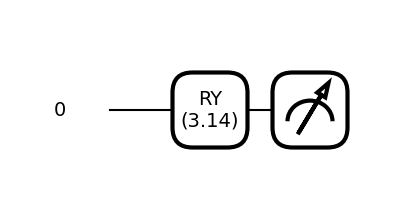

In [98]:
import matplotlib.pyplot as plt

def run():
    #initial_state = [complex(np.sqrt(0.5)), complex(np.sqrt(0.5))]
    initial_state = [complex(1), complex(0)]
    
    theta = 0.01
    eta = 0.1
    iterations = 150
    thetas = [None] * iterations
    costs = [None] * iterations
    for it_num in range(iterations):
        circuit(theta, initial_state)
        thetas[it_num] = theta.real
        costs[it_num] = cost_function(theta, initial_state[0], initial_state[1])
        _, theta = update_rule(theta.real, eta, initial_state)

    qml.draw_mpl(circuit, decimals=2)(theta.real)

    return iterations, thetas, costs
iterations, thetas, costs = run()


### Cost Function vs Iteration \#

Here we plot how the value of the cost function $C(\theta)$ changes over the iterations.

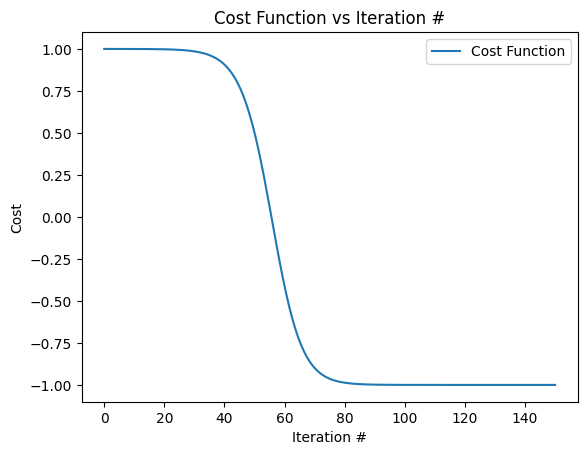

In [100]:
# Plot the cost function vs epoch number
plt.plot(np.linspace(0, iterations, iterations), costs, label="Cost Function")
plt.xlabel("Iteration #")
plt.ylabel("Cost")
plt.title("Cost Function vs Iteration #")
plt.legend()
plt.show()

Feel free to change the initial state, the number of epochs, the learning rate, etc, to see how the cost function changes.